In [ ]:
#@title Point visualization code


def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i + 1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output


def generate_point_html(pil_image, points_json):
    # Convert PIL image to base64 string
    import base64
    from io import BytesIO
    buffered = BytesIO()
    pil_image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode()
    points_json = parse_json(points_json)

    return f"""
<!DOCTYPE html>
<html>
<head>
    <title>Point Visualization</title>
    <style>
        body {{
            margin: 0;
            padding: 0;
            background: #fff;
            color: #000;
            font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
        }}

        .point-overlay {{
            position: absolute;
            top: 0;
            left: 0;
            width: 100%;
            height: 100%;
            pointer-events: none;
        }}

        .point {{
            position: absolute;
            width: 12px;
            height: 12px;
            background-color: #2962FF;
            border: 2px solid #fff;
            border-radius: 50%;
            transform: translate(-50%, -50%);
            box-shadow: 0 0 40px rgba(41, 98, 255, 0.6);
            opacity: 0;
            transition: all 0.3s ease-in;
            pointer-events: auto;
        }}

        .point.visible {{
            opacity: 1;
        }}

        .point.fade-out {{
            animation: pointFadeOut 0.3s forwards;
        }}

        .point.highlight {{
            transform: translate(-50%, -50%) scale(1.1);
            background-color: #FF4081;
            box-shadow: 0 0 40px rgba(255, 64, 129, 0.6);
            z-index: 100;
        }}

        @keyframes pointFadeOut {{
            from {{
                opacity: 1;
            }}
            to {{
                opacity: 0.7;
            }}
        }}

        .point-label {{
            position: absolute;
            background-color: #2962FF;
            color: #fff;
            font-size: 14px;
            padding: 4px 12px;
            border-radius: 4px;
            transform: translate(20px, -10px);
            white-space: nowrap;
            opacity: 0;
            transition: all 0.3s ease-in;
            box-shadow: 0 0 30px rgba(41, 98, 255, 0.4);
            pointer-events: auto;
            cursor: pointer;
        }}

        .point-label.visible {{
            opacity: 1;
        }}

        .point-label.fade-out {{
            opacity: 0.45;
        }}

        .point-label.highlight {{
            background-color: #FF4081;
            box-shadow: 0 0 30px rgba(255, 64, 129, 0.4);
            transform: translate(20px, -10px) scale(1.1);
            z-index: 100;
        }}
    </style>
</head>
<body>
    <div id="container" style="position: relative;">
        <canvas id="canvas" style="background: #000;"></canvas>
        <div id="pointOverlay" class="point-overlay"></div>
    </div>

    <script>
        function annotatePoints(frame) {{
            // Add points with fade effect
            const pointsData = {points_json};

            const pointOverlay = document.getElementById('pointOverlay');
            pointOverlay.innerHTML = '';

            const points = [];
            const labels = [];

            pointsData.forEach(pointData => {{
                // Skip entries without coodinates.
                if (!(pointData.hasOwnProperty("point")))
                  return;

                const point = document.createElement('div');
                point.className = 'point';
                const [y, x] = pointData.point;
                point.style.left = `${{x/1000.0 * 100.0}}%`;
                point.style.top = `${{y/1000.0 * 100.0}}%`;

                const pointLabel = document.createElement('div');
                pointLabel.className = 'point-label';
                pointLabel.textContent = pointData.label;
                point.appendChild(pointLabel);

                pointOverlay.appendChild(point);
                points.push(point);
                labels.push(pointLabel);

                setTimeout(() => {{
                    point.classList.add('visible');
                    pointLabel.classList.add('visible');
                }}, 0);

                // Add hover effects
                const handleMouseEnter = () => {{
                    // Highlight current point and label
                    point.classList.add('highlight');
                    pointLabel.classList.add('highlight');

                    // Fade out other points and labels
                    points.forEach((p, idx) => {{
                        if (p !== point) {{
                            p.classList.add('fade-out');
                            labels[idx].classList.add('fade-out');
                        }}
                    }});
                }};

                const handleMouseLeave = () => {{
                    // Remove highlight from current point and label
                    point.classList.remove('highlight');
                    pointLabel.classList.remove('highlight');

                    // Restore other points and labels
                    points.forEach((p, idx) => {{
                        p.classList.remove('fade-out');
                        labels[idx].classList.remove('fade-out');
                    }});
                }};

                point.addEventListener('mouseenter', handleMouseEnter);
                point.addEventListener('mouseleave', handleMouseLeave);
                pointLabel.addEventListener('mouseenter', handleMouseEnter);
                pointLabel.addEventListener('mouseleave', handleMouseLeave);
            }});
        }}

        // Initialize canvas
        const canvas = document.getElementById('canvas');
        const ctx = canvas.getContext('2d');
        const container = document.getElementById('container');

        // Load and draw the image
        const img = new Image();
        img.onload = () => {{
            const aspectRatio = img.height / img.width;
            canvas.width = 800;
            canvas.height = Math.round(800 * aspectRatio);
            container.style.width = canvas.width + 'px';
            container.style.height = canvas.height + 'px';

            ctx.drawImage(img, 0, 0, canvas.width, canvas.height);

            frame.width = canvas.width;
            frame.height = canvas.height;
            annotatePoints(frame);
        }};
        img.src = 'data:image/png;base64,{img_str}';

        const frame = {{
            width: canvas.width,
            height: canvas.height
        }};

        annotatePoints(frame);
    </script>
</body>
</html>
"""

In [ ]:
import os

import IPython
from PIL import Image
from google import genai
from google.genai import types

GOOGLE_API_KEY = os.getenv("GEMINI_API_KEY")
client = genai.Client(api_key=GOOGLE_API_KEY)

```json
[
  {"point": [300, 820], "label": "0"},
  {"point": [350, 750], "label": "1"},
  {"point": [400, 680], "label": "2"},
  {"point": [450, 620], "label": "3"},
  {"point": [500, 580], "label": "4"},
  {"point": [550, 550], "label": "5"}
]
```



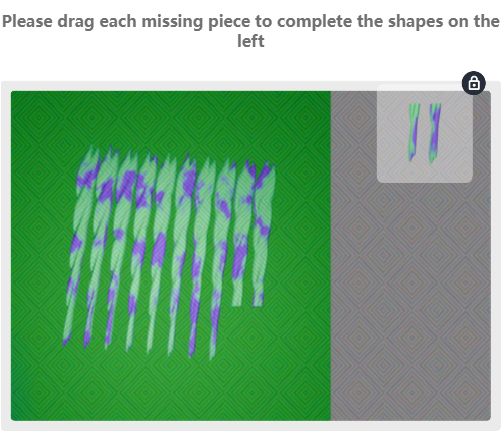

In [21]:
from IPython.display import HTML

img = Image.open("assets/3d_spatial_understanding/single_5.png")

focus_object = "Drag-and-drop, 80x80 segment located on the right side of the image."

prompt = f"""
Point to the {focus_object} and the Points that should be placed, and a trajectory of 6 points connecting them with no more than 10 items.
The points should be labeled by order of the trajectory, from '0' (start point) to <n> (final point)
The answer should follow the json format: [{{"point": <point>, "label": <label1>}}, ...].
The points are in [y, x] format normalized to 0-1000.
"""

# Analyze the image using Gemini.
image_response = client.models.generate_content(
    # model="gemini-2.5-pro-exp-03-25",
    model="gemini-2.5-flash-preview-04-17",
    contents=[img,prompt],
    config=types.GenerateContentConfig(
        temperature=0,
        thinking_config=types.ThinkingConfig(
            thinking_budget=4000
        )
    )
)

# Print the coordinates.
print(image_response.text)

# Display the dots on the image
HTML(generate_point_html(img, image_response.text))